In [1]:
from pathlib import Path
import pandas as pd
from keystrokes.utils.model_utils import load_model

In [4]:
import joblib
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from keystrokes.features.example_creation import ExampleCreator
from keystrokes.features.example_generation import ExampleGenerator
from keystrokes.pipelines.feature_pipeline import FeaturePipeline


from sklearn.utils import shuffle, resample

In [5]:
test_set = "https://www.dropbox.com/s/wr7dk90rqqdfdda/test_data.csv?dl=1"
df = pd.read_csv(test_set)

df_majority = df[df.labels == 0]
df_minority = df[df.labels == 1]

# Downsample minority class
df_minority_downsampled = resample(
    df_minority, replace=False, n_samples=int(len(df_majority) * 0.01), random_state=123
)

# Combine minority class with majority class
df = shuffle(pd.concat([df_majority, df_minority_downsampled]))

In [6]:
y = df['labels']
X = df.drop(columns='labels')

In [7]:
y.value_counts()

labels
0    30024
1      300
Name: count, dtype: int64

In [8]:
model_url = "https://www.dropbox.com/s/yiitiwjct2zxhfi/model.joblib?dl=1"
model = load_model(model_url)

Model downloaded successfully.


In [14]:
thresh = 0.9
y_pred_proba = model.predict_proba(X)[:,1]
y_pred = (y_pred_proba >= thresh).astype(int)
accuracy = accuracy_score(y, y_pred)

Accuracy: 96.86%
AUC-ROC: 0.97
AUC-PR: 0.64


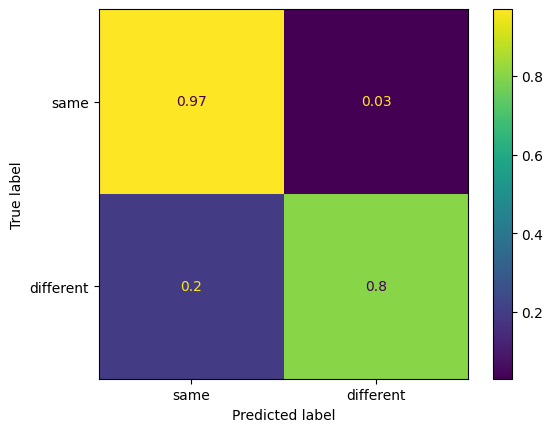

In [15]:
# Step 6: AUC-ROC
roc_auc = roc_auc_score(y, y_pred_proba)
# Step 7: Confusion Matrix
cf_matrix = confusion_matrix(y, y_pred)
# Step 8: AUC-PR (Area Under the Precision-Recall Curve)
precision, recall, _ = precision_recall_curve(y, y_pred_proba)
auc_pr = auc(recall, precision)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC-ROC: %.2f" % roc_auc)
print("AUC-PR: %.2f" % auc_pr)


ConfusionMatrixDisplay.from_predictions(
    y_true=y, y_pred=y_pred, normalize="true", display_labels=["same", "different"]
)
plt.show()

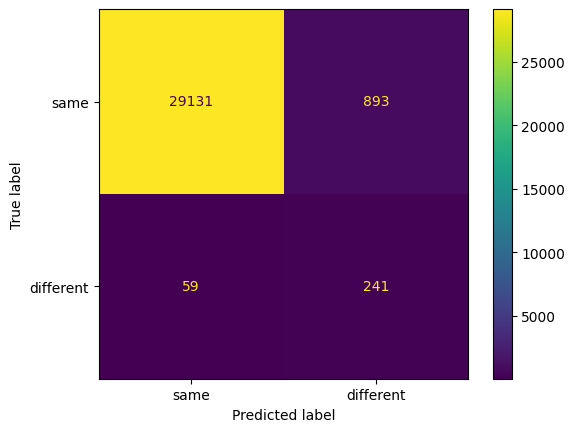

In [16]:
ConfusionMatrixDisplay.from_predictions(
    y_true=y, y_pred=y_pred, display_labels=["same", "different"]
)
plt.show()

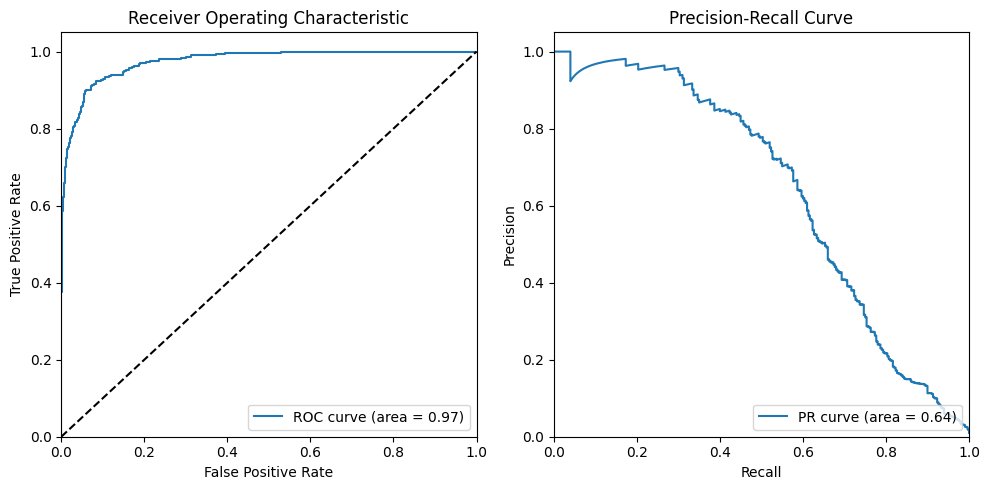

In [17]:
# Step 6: ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Step 7: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

# Show plots
plt.tight_layout()
plt.show()